<a href="https://colab.research.google.com/github/naufalfrdss/DeepLearning/blob/main/Week%203/Assignment/CIFAR-10%20Dataset/CIFAR_10_Using_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Library

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.datasets import CIFAR10

## Data Preparation

In [2]:
# Transformations & Augmentation
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.RandomCrop(32, padding=4),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
])

# Load datasets
train_dataset = CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = CIFAR10(root='./data', train=False, download=True, transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
]))
# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False,  num_workers=4, pin_memory=True)

# Class names (same as TFDS)
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(class_names)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
scaler = torch.cuda.amp.GradScaler(init_scale=2.**16)
criterion = nn.CrossEntropyLoss()

C:\Users\Naufal Firdaus\AppData\Local\Temp\ipykernel_23440\2484626750.py:2: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(init_scale=2.**16)


In [4]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.001):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = np.inf
        self.counter = 0

    def check_early_stop(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
        return self.counter >= self.patience

early_stopper = EarlyStopping(patience=5)

## CNN Model

In [7]:
class PyTorchCNN(nn.Module):
    def __init__(self):
        super(PyTorchCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(256 * 4 * 4, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 10)
        )

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

pytorch_cnn_model = PyTorchCNN().to(device)

In [8]:
cnn_optimizer = optim.Adam(pytorch_cnn_model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = OneCycleLR(
    cnn_optimizer, max_lr=0.01, steps_per_epoch=len(train_loader), epochs=50
)

In [9]:
def train_pytorch_cnn(model, optimizer, train_loader, test_loader, scheduler=None, epochs=35):
    train_losses, test_losses = [], []
    train_accs, test_accs = [], []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()

            with torch.amp.autocast("cuda"):
                outputs = model(images)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            if scheduler:
                scheduler.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = 100 * correct / total
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        model.eval()
        test_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                test_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        test_loss = test_loss / len(test_loader)
        test_acc = 100 * correct / total
        test_losses.append(test_loss)
        test_accs.append(test_acc)

        print(f'Epoch {epoch+1}/{epochs} Train Acc: {train_acc:.2f}% Test Acc: {test_acc:.2f}%')

        if early_stopper.check_early_stop(test_loss):
            break

    return train_losses, test_losses, train_accs, test_accs

print("Training PyTorch CNN:")
pytorch_cnn_train_loss, pytorch_cnn_test_loss, pytorch_cnn_train_acc, pytorch_cnn_test_acc = train_pytorch_cnn(
    pytorch_cnn_model, cnn_optimizer, train_loader, test_loader, scheduler=scheduler
)

Training PyTorch CNN:
Epoch 1/35 Train Acc: 23.37% Test Acc: 32.53%
Epoch 2/35 Train Acc: 34.13% Test Acc: 40.68%
Epoch 3/35 Train Acc: 39.90% Test Acc: 49.02%
Epoch 4/35 Train Acc: 44.58% Test Acc: 51.66%
Epoch 5/35 Train Acc: 46.52% Test Acc: 56.26%
Epoch 6/35 Train Acc: 48.00% Test Acc: 57.77%
Epoch 7/35 Train Acc: 48.97% Test Acc: 54.78%
Epoch 8/35 Train Acc: 50.07% Test Acc: 57.83%
Epoch 9/35 Train Acc: 52.52% Test Acc: 61.82%
Epoch 10/35 Train Acc: 54.45% Test Acc: 61.15%
Epoch 11/35 Train Acc: 57.43% Test Acc: 65.50%
Epoch 12/35 Train Acc: 60.68% Test Acc: 69.65%
Epoch 13/35 Train Acc: 62.78% Test Acc: 63.99%
Epoch 14/35 Train Acc: 65.71% Test Acc: 70.04%
Epoch 15/35 Train Acc: 66.93% Test Acc: 65.91%
Epoch 16/35 Train Acc: 68.78% Test Acc: 74.45%
Epoch 17/35 Train Acc: 70.29% Test Acc: 72.10%
Epoch 18/35 Train Acc: 71.08% Test Acc: 73.49%
Epoch 19/35 Train Acc: 72.24% Test Acc: 73.39%
Epoch 20/35 Train Acc: 72.78% Test Acc: 74.37%
Epoch 21/35 Train Acc: 73.81% Test Acc: 77.44%


In [14]:
def evaluate_model(model, test_loader, num_classes=10):
    model.eval()
    y_true, y_pred, y_score = [], [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
            y_score.extend(probs.cpu().numpy())

    # Convert to numpy arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_score = np.array(y_score)

    acc = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
    cm = confusion_matrix(y_true, y_pred)

    print("\n========= Evaluation Metrics =========")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall   : {recall:.4f}")
    print(f"F1-Score : {f1:.4f}")
    print("======================================")

    # ROC AUC Score (macro-averaged)
    y_true_bin = label_binarize(y_true, classes=list(range(num_classes)))
    try:
        auc = roc_auc_score(y_true_bin, y_score, average='macro', multi_class='ovr')
        print(f"AUC-ROC  : {auc:.4f}")
    except ValueError as e:
        print("AUC-ROC can't be computed:", e)

    # Confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=False, fmt='d', cmap='Blues')
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()



========= Evaluation Metrics =========
Accuracy : 0.8380
Precision: 0.8438
Recall   : 0.8380
F1-Score : 0.8383
AUC-ROC  : 0.9859


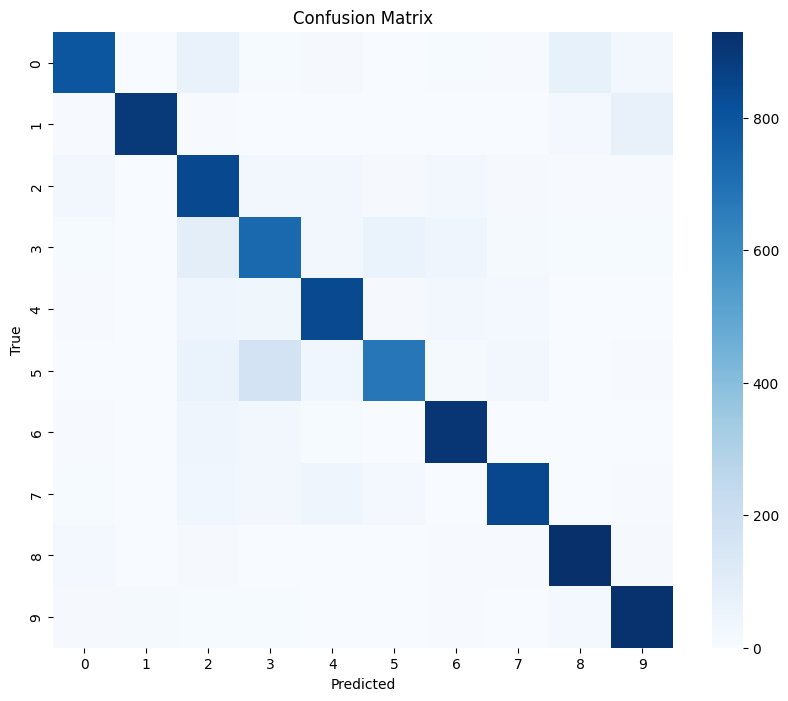

In [15]:
evaluate_model(pytorch_cnn_model, test_loader)

## MLP Model

In [62]:
batch_size = 64
learning_rate = 0.001
num_epochs = 10

In [63]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32*32*3, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        return self.model(x)

In [64]:
model = MLP()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [65]:
def train():
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(train_loader):.4f}")


In [66]:
train()

Epoch [1/10], Loss: 1.9143
Epoch [2/10], Loss: 1.7424
Epoch [3/10], Loss: 1.6711
Epoch [4/10], Loss: 1.6273
Epoch [5/10], Loss: 1.5886
Epoch [6/10], Loss: 1.5651
Epoch [7/10], Loss: 1.5395
Epoch [8/10], Loss: 1.5230
Epoch [9/10], Loss: 1.5113
Epoch [10/10], Loss: 1.4861


In [82]:
from sklearn.metrics import auc

def evaluate(loader, is_test=True):
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)

            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds, average='macro')
    rec = recall_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')

    print(f"{'Test' if is_test else 'Train'} Accuracy: {acc*100:.2f}%")
    print(f"Precision: {prec:.4f}, Recall: {rec:.4f}, F1 Score: {f1:.4f}")

    # ROC and AUC for multi-class
    y_true = label_binarize(all_labels, classes=list(range(10)))
    y_score = np.array(all_probs)

    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(10):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Macro-average AUC
    all_auc = roc_auc_score(y_true, y_score, average='macro', multi_class='ovr')
    print(f"\nMacro-Averaged AUC Score: {all_auc:.4f}")

    # ROC Curve Plot
    plt.figure(figsize=(10, 8))
    for i in range(10):
        plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {"Test" if is_test else "Train"} Set')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()


Train Accuracy: 46.82%
Precision: 0.4617, Recall: 0.4682, F1 Score: 0.4599

Macro-Averaged AUC Score: 0.8724


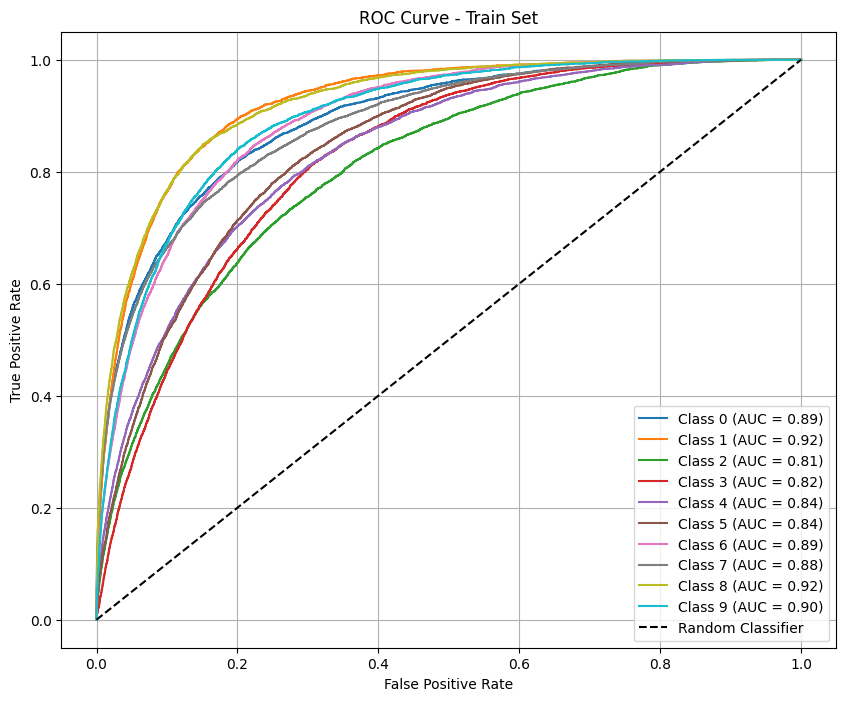

Test Accuracy: 36.53%
Precision: 0.3886, Recall: 0.3653, F1 Score: 0.3496

Macro-Averaged AUC Score: 0.8059


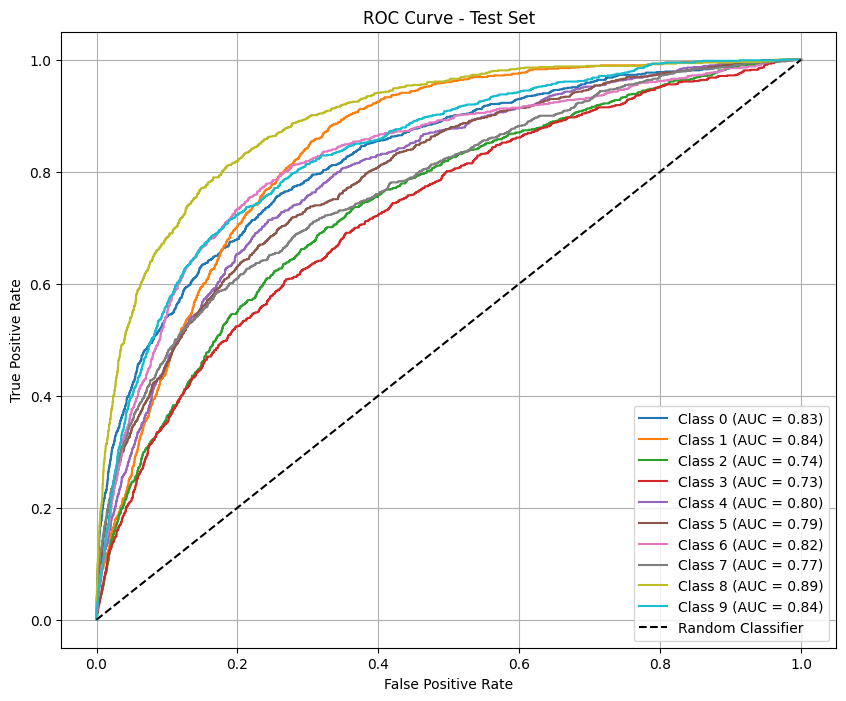

In [83]:
evaluate(train_loader, is_test=False)
evaluate(test_loader, is_test=True)

## Penjelasan Matematis

outputs: hasil output mentah dari MLP.

softmax: digunakan untuk mengubah outputs menjadi probabilitas untuk masing-masing kelas.

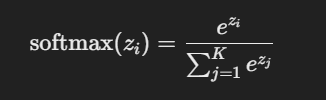

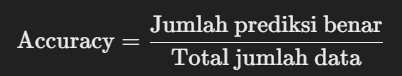

Precision (macro): Rata-rata dari precision tiap kelas:

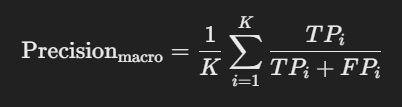

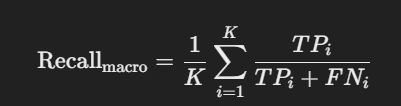

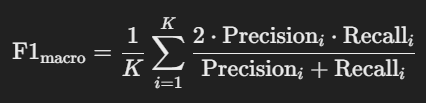

ROC Curve: grafik antara True Positive Rate (TPR) dan False Positive Rate (FPR):

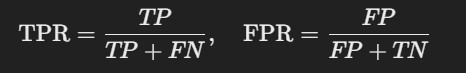

AUC (Area Under Curve): Luas area di bawah ROC curve. Semakin dekat ke 1.0, semakin baik.

Macro-Averaged AUC: Rata-rata AUC dari seluruh kelas:

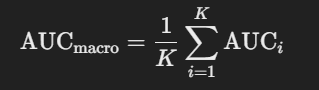